Variables:

- flag superficie imputada
- 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from malbecs.modeling import train as tr

wine_path = "../../data/final/wine_final.csv"
eto_path = "../../data/final/eto_final.csv"
meteo_path = "../../data/final/meteo_final.csv"

def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6, 15))


In [17]:

data = tr.load_final_data(
    wine_path=wine_path,
    eto_path=eto_path,
    meteo_path=meteo_path
)

with open("../../data/final/meteo_features.txt", "r", encoding="utf-8") as f:
    meteo_cols = f.read().split("\n")

with open("../../data/final/eto_features.txt", "r") as f:
    eto_cols = f.read().split("\n")

with open("../../data/final/wine_features.txt", "r") as f:
    wine_cols = f.read().split("\n")


In [18]:
# [c for c in wine_cols if "_he" in c]

In [19]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, StandardScaler
import pickle as pkl
from typing import List
import malbecs.modeling.transformers as mt

seed = 42

def get_base_model():

    model_num_cols = [
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
    ]

    m = make_pipeline(
        make_column_transformer(

            (mt.BaseNEncoder(), ['id_finca']),

            (mt.TargetEncoder(), ['id_zona']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['id_estacion']),

            (mt.BaseNEncoder(), ['variedad']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['modo']),

            (KBinsDiscretizer(n_bins=2), ['altitud']),

            (StandardScaler(), model_num_cols),

            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=4,
            n_jobs=-1,
            max_features='sqrt',
            max_samples=0.8
        )
    )
    return m


In [21]:
m = get_base_model()

In [22]:
from sklearn.model_selection import cross_validate
import numpy as np

res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)


print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4950.42915184 -4769.7101927  -4818.80517865]
test:  [-4867.31956362 -6767.87298344 -5430.5269726 ]
Train Mean RMSE: -4846.314841064502
Test Mean RMSE: -5688.573173223823


In [23]:
percip_cols = [c for c in eto_cols if "Precip" in c]
snow_cols = [c for c in eto_cols if "Snow" in c]
temp_day_cols = [c for c in eto_cols if "TemperatureLocalDay" in c]
temp_cols = [
    c for c in eto_cols 
    if "TemperatureLocalAfter" in c or "TemperatureLocalOvern" in c
]
evotrans_cols = [c for c in eto_cols if "Evapotranspiration" in c]
feelslike_cols = [c for c in eto_cols if "FeelsLikeLoca" in c]
irrad_cols = [c for c in eto_cols if "Irradiance" in c]
gust_cols = [c for c in eto_cols if "Gust" in c]
wind_cols = [c for c in eto_cols if "Wind" in c]
dewpoint_cols = [c for c in eto_cols if "Dewpoint" in c]
mslp_cols = [c for c in eto_cols if "MSLP" in c]
humid_cols = [c for c in eto_cols if "Humidity" in c]
uvindex_cols = [c for c in eto_cols if "UVIndex" in c]
visib_cols = [c for c in eto_cols if "Visibility" in c]

In [24]:
tempuo = [c for c in eto_cols if ("Temp" in c) and ("StdM" in c )]
precipuo = [c for c in eto_cols if ("Precip" in c) and ("StdM" in c )]
snowpuo = [c for c in eto_cols if ("Snow" in c) and ("StdM" in c )]
winduo = [c for c in eto_cols if ("Wind" in c) and ("StdM" in c )]
gustuo = [c for c in eto_cols if ("Gust" in c) and ("StdM" in c)]

# Under Over Features

In [25]:
from sklearn.decomposition import PCA


def get_preprocesing():

    model_num_cols = [
        # 'altitud',
        'campaña',
        'superficie',
        # 'sup_shift1',
        # 'prod_shift1',
        # 'prod_shift2',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        # 'prod_he_shift1_total',
        # 'prod_he_shift2_total',
        # 'prod_he_shift_change_total',
        # 'prod_he_shift_avg_total',
        'prod_he_var_zone_mean_hist_total',
        'prod_he_var_zone_std_hist_total',
        # 'prod_he_var_mean_hist_total',
        # 'prod_he_var_std_hist_total',
        'prod_he_var_modo_zona_mean_shift1_total',
        "prod_he_var_modo_zona_change_total"
        # 'prod_he_zone_std_total',
        # 'prod_he_var_mean_total',
        # 'prod_he_var_std_total'
    ]

    return make_column_transformer(

        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['sup_is_nan']),

        # (mt.BaseNEncoder(), ['id_finca']),
        # (mt.TargetEncoder(), ['id_finca']),
        # (mt.QuantileFeatureEncoder(col='id_finca'), ['id_finca']),
        # (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['id_finca']),
        # (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_finca_top']),
         
        # (mt.TargetEncoder(), ['id_zona']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_zona']),

        # (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_estacion']),

        # (mt.BaseNEncoder(), ['variedad']), 
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['variedad']),
        # (mt.QuantileFeatureEncoder(qs=np.linspace(0.1, 0.9, 9).tolist(), col='variedad'), ['variedad']),

        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['modo']),

        # (KBinsDiscretizer(n_bins=3, encode='ordinal'), ['altitud']),
        # (KBinsDiscretizer(n_bins=5, encode='ordinal'), ['prod_shift2']),

        (StandardScaler(), model_num_cols),
        
        # (StandardScaler(),temp_cols),

        (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), temp_cols),
        
        # (KBinsDiscretizer(n_bins=2), [c for c in temp_day_cols if "Avg" in c]),

        # (StandardScaler(), [c for c in temp_day_cols if "Avg" in c]),
        # (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), [c for c in temp_day_cols if "Avg" in c]),

        # (StandardScaler(),[c for c in meteo_cols if "avg_daytime" in c]),
        # (make_pipeline(StandardScaler(), PCA(n_components=2, random_state=seed)), [
        #  c for c in meteo_cols if "avg_daytime" in c]),
        
        
        # (StandardScaler(),precipuo),
        # (StandardScaler(),tempuo),
        # (StandardScaler(),winduo),
        # (StandardScaler(),gustuo),
        # (StandardScaler(),[c for c in snowpuo if "Month1" in c or "Month2" in c or "Month3" in c])

        (StandardScaler(),[c for c in precipuo if "2Std" in c]),
        # (StandardScaler(),[c for c in winduo if "2Std" in c]),
        # (StandardScaler(),[c for c in tempuo if "2Std" in c]),
        # (StandardScaler(),[c for c in gustuo if "2Std" in c]),
        # (StandardScaler(),[c for c in snowpuo if "Month1" in c or "Month2" in c or "Month3" in c]),

        (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)),
             [c for c in percip_cols if 'Sum' in c]
        ),

        # (StandardScaler(),[c for c in snow_cols if 'Sum' in c and ("1" in c or "2" in c)]),
        
        # (StandardScaler(), [c for c in gust_cols if 'Max' in c ]),

        # (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), [c for c in gust_cols if 'Max' in c ]),

        # (StandardScaler(),[c for c in humid_cols if "Avg" in c]),
        # (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), [c for c in humid_cols if "Avg" in c]),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), uvindex_cols),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), dewpoint_cols),
        # (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), wind_cols),


        remainder='drop'
    )


In [26]:
from sklearn.ensemble import StackingRegressor, VotingRegressor

prep = get_preprocesing()
# model = LinearRegression()
# model = Lasso(random_state=seed)
# model = Ridge(random_state=seed)
# model = ElasticNet(random_state=seed)

model = RandomForestRegressor(
    random_state=seed,
    n_estimators=400,
    min_samples_leaf=4,
    # max_depth=8,
    n_jobs=-1,
    max_features=0.20,
    max_samples=0.8
    # random_state=seed,
    # n_estimators=400,
    # n_jobs=-1,
    # max_features=1.0,
    # max_samples=1.0
)

m = make_pipeline(
    prep,
    model
)



In [27]:
res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,
    fit_params={
        # "randomforestregressor__sample_weight": sample_weight
        # "stackingregressor__sample_weight": sample_weight
    }
)

print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")


# base
# train:  [-4950.42915184 - 4769.7101927 - 4818.80517865]
# test:  [-4867.31956362 - 6767.87298344 - 5430.5269726]
# Train Mean RMSE: -4846.314841064502
# Test Mean RMSE: -5688.573173223823


train:  [-4806.66560427 -4532.06326068 -4575.46702604]
test:  [-4866.36799055 -6705.91673524 -5327.22816224]
Train Mean RMSE: -4638.065296996015
Test Mean RMSE: -5633.17096267967


In [259]:
# X['prod_he_shift_change_total']

#### Modelo nuevo - PCAs temp + nuevas producciones segun otras variables

In [76]:
from sklearn.decomposition import PCA


def get_preprocesing():

    model_num_cols = [
        # 'altitud',
        'campaña',
        'superficie',
        # 'sup_shift1',
        # 'prod_shift1',
        # 'prod_shift2',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        # 'prod_he_shift1_total',
        # 'prod_he_shift2_total',
        # 'prod_he_shift_change_total',
        # 'prod_he_shift_avg_total',
        'prod_he_var_zone_mean_hist_total',
        'prod_he_var_zone_std_hist_total',
        # 'prod_he_var_mean_hist_total',
        # 'prod_he_var_std_hist_total',
        'prod_he_zone_mean_total',
        # 'prod_he_zone_std_total',
        # 'prod_he_var_mean_total',
        # 'prod_he_var_std_total'
    ]

    return make_column_transformer(

        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['sup_is_nan']),

        # (mt.BaseNEncoder(), ['id_finca']),
        # (mt.TargetEncoder(), ['id_finca']),
        # (mt.QuantileFeatureEncoder(col='id_finca'), ['id_finca']),
        (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['id_finca']),
        # (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_finca_top']),
         
        (mt.TargetEncoder(), ['id_zona']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_zona']),

        # (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_estacion']),

        # (mt.BaseNEncoder(), ['variedad']), 
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['variedad']),
        # (mt.QuantileFeatureEncoder(qs=np.linspace(0.1, 0.9, 9).tolist(), col='variedad'), ['variedad']),

        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['modo']),

        # (KBinsDiscretizer(n_bins=3, encode='ordinal'), ['altitud']),
        # (KBinsDiscretizer(n_bins=5, encode='ordinal'), ['prod_shift2']),

        (StandardScaler(), model_num_cols),
        
        # (StandardScaler(),temp_cols),

        # (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), temp_cols),
        
        # (KBinsDiscretizer(n_bins=2), [c for c in temp_day_cols if "Avg" in c]),

        # (StandardScaler(), [c for c in temp_day_cols if "Avg" in c]),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), [c for c in temp_day_cols if "Avg" in c]),

        # (StandardScaler(),[c for c in meteo_cols if "avg_daytime" in c]),
        # (make_pipeline(StandardScaler(), PCA(n_components=2, random_state=seed)), [
        #  c for c in meteo_cols if "avg_daytime" in c]),
        

        # (StandardScaler(),[c for c in percip_cols if 'Sum' in c]),

        
        (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)),
             [c for c in percip_cols if 'Sum' in c]
        ),

        
        (StandardScaler(),[c for c in snow_cols if 'Sum' in c and ("1" in c or "2" in c)]),
        
        # (StandardScaler(), [c for c in gust_cols if 'Max' in c ]),

        (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), [c for c in gust_cols if 'Max' in c ]),

        # (StandardScaler(),[c for c in humid_cols if "Avg" in c]),
        # (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), [c for c in humid_cols if "Avg" in c]),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), uvindex_cols),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), dewpoint_cols),
        # (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), wind_cols),


        remainder='drop'
    )


In [77]:
from sklearn.ensemble import StackingRegressor, VotingRegressor

prep = get_preprocesing()
# model = LinearRegression()
# model = Lasso(random_state=seed)
# model = Ridge(random_state=seed)
# model = ElasticNet(random_state=seed)

model = RandomForestRegressor(
    random_state=seed,
    n_estimators=500,
    min_samples_leaf=4,
    # max_depth=8,
    n_jobs=-1,
    max_features=0.20,
    max_samples=0.8
    # random_state=seed,
    # n_estimators=400,
    # n_jobs=-1,
    # max_features=1.0,
    # max_samples=1.0
)


# model = StackingRegressor(
#     estimators=[(
#         f"rf_{i}",
#         RandomForestRegressor(
#             random_state=seed+i,
#             n_estimators=[300,200,200,80][i],
#             min_samples_leaf=[3,4,4,5][i],
#             n_jobs=-1,
#             max_features=['sqrt', 'sqrt', 'sqrt',0.5][i],
#             max_samples=0.8
#         ) 
#     ) for i in range(4)],
#     final_estimator = make_pipeline(StandardScaler(),Ridge()),
# )

# model = VotingRegressor(
#     estimators=[(
#         f"rf_{i}",
#         RandomForestRegressor(
#             random_state=seed+i,
#             n_estimators=500,
#             min_samples_leaf=4,
#             n_jobs=-1,
#             max_features=0.2,
#             max_samples=0.8
#         )
#     ) for i in range(5)],
#     # final_estimator=make_pipeline(StandardScaler(), LinearRegression()),
# )

m = make_pipeline(
    prep,
    model
)

# sample_weight = X['campaña'].apply(lambda x: 0.5 if x == 20 else 1).values

# sample_weight = X['campaña'].apply(lambda x: x/22)

# sample_weight = X['campaña'].apply(lambda x: 1)

# sample_weight = X['campaña'].apply(lambda x: 0.2 if x <= 19 else 1)


In [78]:
res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,
    fit_params={
        # "randomforestregressor__sample_weight": sample_weight
        # "stackingregressor__sample_weight": sample_weight
    }
)


print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4634.98885712 -4404.44860405 -4461.27941723]
test:  [-4761.95495808 -6678.08234653 -5354.3150231 ]
Train Mean RMSE: -4500.238959466138
Test Mean RMSE: -5598.117442571248


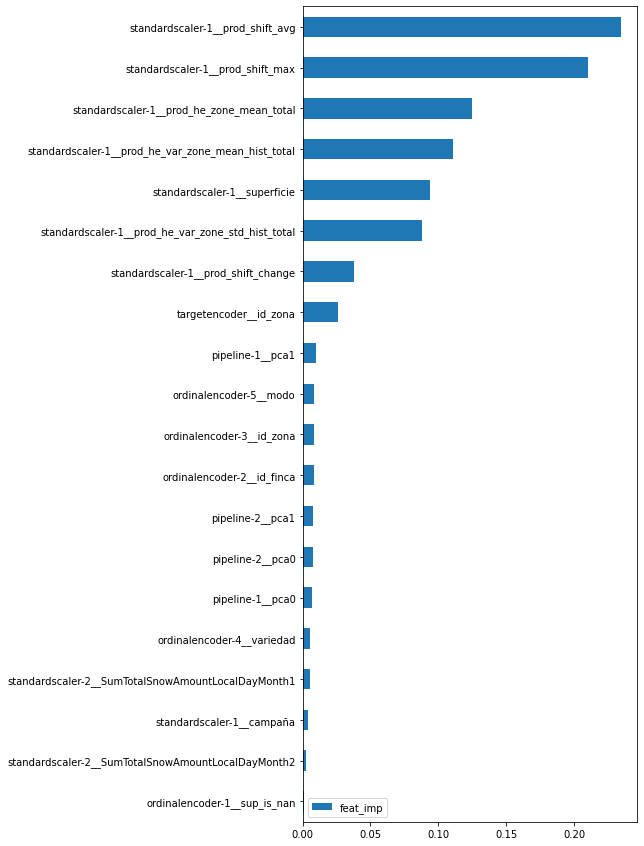

In [79]:
m.fit(X,y)
show_feat_imps(
    m[-1].feature_importances_,
    m[:-1].get_feature_names_out(),
)


#### Comparar predicciones modelo nuevo vs original

In [80]:
#Originales

df_preds = pd.read_csv('../../data/final/Malbecs.txt',sep='|',header=None)
preds_originales = df_preds[6]

In [81]:
x_test_v2 = data_final.drop(columns=['produccion'])

In [82]:
preds_nuevas = m.predict(x_test_v2)

In [85]:
preds_final_2 = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final_2['produccion'] = preds_nuevas
preds_final_2 = preds_final_2.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

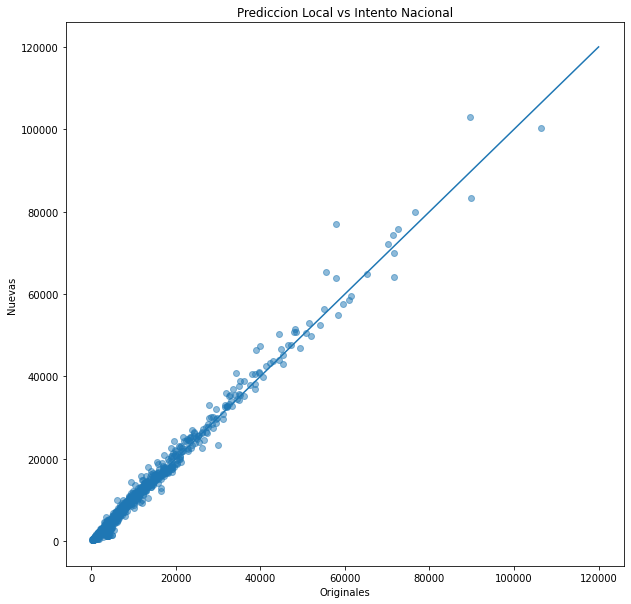

In [86]:
plt.figure(figsize=(10,10))
plt.scatter(preds_originales, preds_final_2['produccion'], alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Originales')
plt.ylabel('Nuevas')
plt.title('Prediccion Local vs Intento Nacional')
plt.show()

In [87]:
preds_final_2.to_csv('../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_2.txt', sep="|", header=None, index=False)

#### Comparar predicciones modelo original + clima vs original

In [38]:
#Originales

df_preds = pd.read_csv('../../data/final/Malbecs.txt',sep='|',header=None)
preds_originales = df_preds[6]

In [60]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, StandardScaler
import pickle as pkl
from typing import List
import malbecs.modeling.transformers as mt

seed = 42

def get_base_model_v2():

    model_num_cols = [
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
    ]

    m = make_pipeline(
        make_column_transformer(

            (mt.BaseNEncoder(), ['id_finca']),

            (mt.TargetEncoder(), ['id_zona']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['id_estacion']),

            (mt.BaseNEncoder(), ['variedad']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['modo']),

            (KBinsDiscretizer(n_bins=2), ['altitud']),

            (StandardScaler(), model_num_cols),

            (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)),[c for c in percip_cols if 'Sum' in c]),
            
            (StandardScaler(),[c for c in snow_cols if 'Sum' in c and ("1" in c or "2" in c)]),

            #(make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), [c for c in gust_cols if 'Max' in c ]),

            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=4,
            n_jobs=-1,
            max_features='sqrt',
            max_samples=0.8
        )
    )
    return m


In [61]:
m_nuevo = get_base_model_v2()
res = cross_validate(
    estimator=m_nuevo,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,
    fit_params={
        # "randomforestregressor__sample_weight": sample_weight
        # "stackingregressor__sample_weight": sample_weight
    }
)


print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4727.2469563  -4541.35514995 -4601.38580505]
test:  [-4867.83389351 -6638.79785759 -5433.38564627]
Train Mean RMSE: -4623.329303766486
Test Mean RMSE: -5646.672465790679


In [62]:
m_nuevo = get_base_model_v2()
m_nuevo.fit(X,y)
preds_nuevas = m_nuevo.predict(x_test_v2)

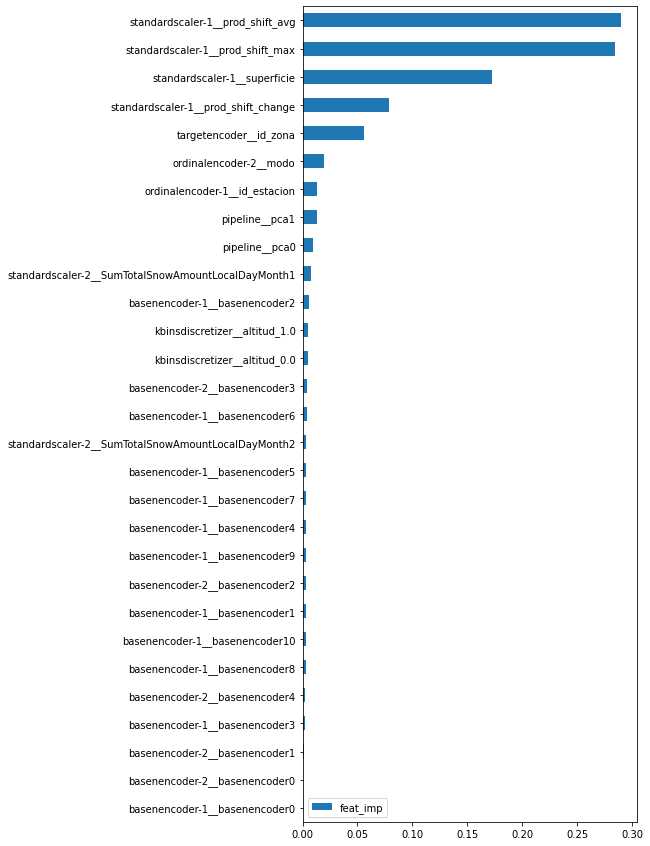

In [63]:
show_feat_imps(
    m_nuevo[-1].feature_importances_,
    m_nuevo[:-1].get_feature_names_out(),
)


In [66]:
preds_final_v2 = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final_v2['produccion'] = preds_nuevas
preds_final_v2 = preds_final_v2.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

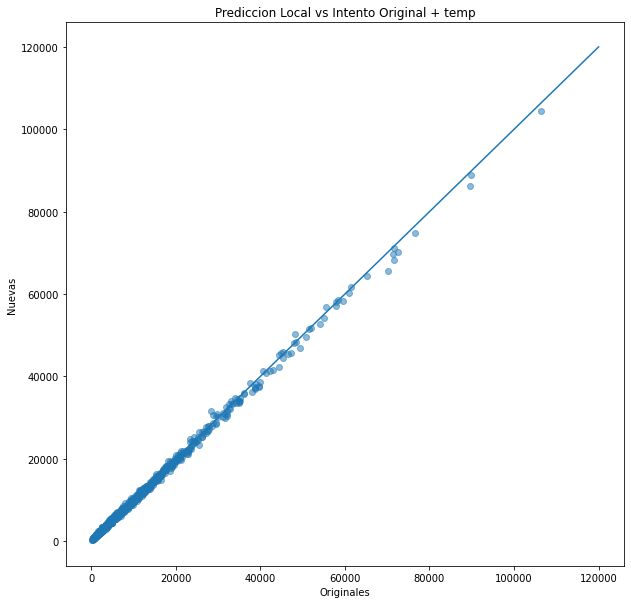

In [68]:
plt.figure(figsize=(10,10))
plt.scatter(preds_originales, preds_final_v2['produccion'], alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Originales')
plt.ylabel('Nuevas')
plt.title('Prediccion Local vs Intento Original + temp')
plt.show()

In [67]:
preds_final_v2

,id_finca,variedad,modo,tipo,color,superficie,produccion
9498,439,9,2,0,0,1.0800,3847.994307
8923,447,40,2,0,1,0.4694,2647.855934
8602,523,32,2,0,1,0.6478,2093.686110
9242,702,59,2,0,1,1.1331,8143.693395
8750,797,59,1,0,1,7.5143,12131.850378
...,...,...,...,...,...,...,...
9236,99282,59,2,0,1,1.6244,7611.700026
9117,99377,52,2,0,1,0.6500,2458.847053
9320,99693,81,1,0,1,6.3397,28641.610416
9036,99793,52,2,0,1,0.1326,4068.094352


In [72]:
preds_final_v2.to_csv('../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_1.txt', sep="|", header=None, index=False)

## Resto pruebas

In [1093]:
from numpy import linspace
from sklearn.model_selection import GridSearchCV

param_grid = {
    'randomforestregressor__max_features': [0.18,0.2,0.22],
    # 'randomforestregressor__max_depth': [4, 5, 6, 8],
    # 'randomforestregressor__max_samples': [0.8], 
    # 'randomforestregressor__min_samples_leaf':[3,4],
    'randomforestregressor__n_estimators': [180,200,300,400,500],
    # 'randomforestregressor__ccp_alpha': [0,0.01,0.02],
}
# param_grid = 
#     'lasso__alpha':linspace(150,160,10)
# }
# param_grid = {
#     'ridge__alpha': linspace(860, 870, 10)
# }
# param_grid = {
#     'elasticnet__alpha': linspace(0.1,1, 10),
#     'elasticnet__l1_ratio': [0.6,0.7,0.8]
# }

gsm = GridSearchCV(
    m,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=tr.rmse_scorer
)

gsm.fit(
    X, 
    y, 
    # randomforestregressor__sample_weight=sample_weight
    )

print(gsm.best_params_)
print(gsm.best_score_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'randomforestregressor__max_features': 0.2, 'randomforestregressor__n_estimators': 200}
-5582.862128800595


In [1073]:
print(gsm.best_params_)
print(gsm.best_score_)

{'randomforestregressor__max_features': 0.2, 'randomforestregressor__n_estimators': 200}
-5582.862128800595


In [1094]:
# m = gsm.best_estimator_
# y_pred = m.fit(X_train, y_train).predict(X_test)
# score_model(X_test, y_test, y_pred, sup_norm=False)

res = cross_validate(
    estimator=gsm.best_estimator_,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,
    # fit_params={
    #     "randomforestregressor__sample_weight": sample_weight
    # }
)

print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")


train:  [-4640.87405913 -4411.70027673 -4457.60633498]
test:  [-4744.64558641 -6684.14068564 -5319.80011435]
Train Mean RMSE: -4503.393556947637
Test Mean RMSE: -5582.862128800595
